# 基于return based方法对比资产/因子配置的结果

In [1]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.plotting import plot_efficient_frontier

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

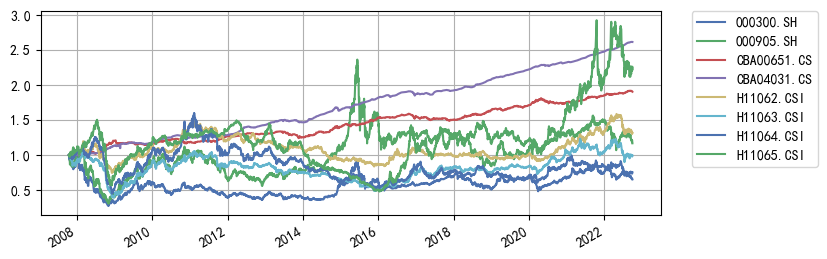

In [2]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
(asset_data_raw.dropna()/asset_data_raw.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [3]:
asset_alpha = pd.read_csv(os.path.join(this_path, '../data/assets/asset_alpha.csv'), index_col=0)
asset_alpha.index = pd.to_datetime(asset_alpha.index)
asset_alpha_pca = pd.read_csv(os.path.join(this_path, '../data/assets/asset_alpha_pca.csv'), index_col=0)
asset_alpha_pca.index = pd.to_datetime(asset_alpha_pca.index)

In [4]:
class MvoStrategy(Strategy):
    def __init__(self, asset_alpha=None, weight_bounds=[0, 1], total_weight=[0.99, 1], target_return=None, target_risk=None, max_sharp=False, **kwargs):
        super().__init__()
        self._asset_alpha = asset_alpha
        self._weight_bounds = weight_bounds
        self._total_weight = total_weight
        self._target_return = target_return
        self._target_risk = target_risk
        self._max_sharp = max_sharp

    def run(self, id_date, asset_data):
        if self._asset_alpha is None:
            mu = expected_returns.mean_historical_return(asset_data, returns_data=False)
        else:
            mu = self._asset_alpha.loc[asset_data.index[-1]].reindex(asset_data.columns).fillna(0)
        s = risk_models.sample_cov(asset_data, returns_data=False)
        ef = EfficientFrontier(mu, s, weight_bounds=self._weight_bounds)

        if self._total_weight:
            sector_mapper = {a:'all' for a in asset_data.columns}
            ef.add_sector_constraints(sector_mapper, sector_lower={'all':self._total_weight[0]}, sector_upper={'all':self._total_weight[1]})

        # plot_efficient_frontier(ef)
        # sys.exit(1)
        try:
            if self._max_sharp:
                _ = ef.max_sharpe()
            elif self._target_return:
                _ = ef.efficient_return(self._target_return)
            elif self._target_risk:
                _ = ef.efficient_risk(self._target_risk)
            weights = ef.clean_weights()
        except Exception as e:
            print(e)
            weights = [np.nan] * asset_data.shape[1]
        # print(weights)
        # sys.exit(1)

        return pd.Series(weights, index=asset_data.columns)

## 1. max sharpe

In [5]:
date_range = [datetime(2019,1,31), datetime(2021,12,31)]
asset_max_sharpe_backtest = BacktestManager(
    MvoStrategy(max_sharp=True), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
asset_max_sharpe_backtest.run()

100%|██████████| 709/709 [00:06<00:00, 104.25it/s]


<AxesSubplot:>

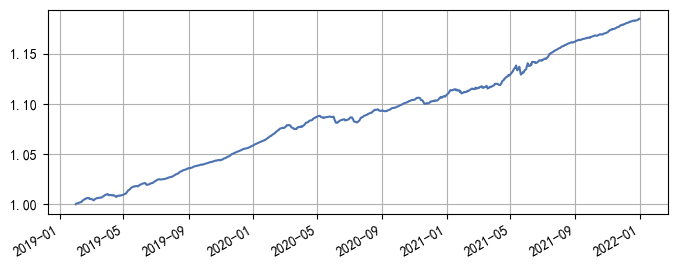

In [6]:
asset_max_sharpe_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

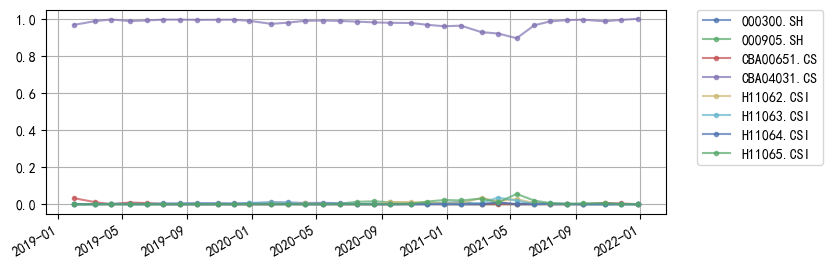

In [7]:
weights = pd.concat(list(asset_max_sharpe_backtest._historcial_weights.values()), axis=1).T
weights.index = list(asset_max_sharpe_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [8]:
factor_max_sharpe_backtest = BacktestManager(
    MvoStrategy(max_sharp=True, asset_alpha=asset_alpha), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
factor_max_sharpe_backtest.run()

 11%|█         | 79/709 [00:01<00:08, 73.63it/s]

Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
2019-05-16 00:00:00: skip


 44%|████▎     | 309/709 [00:04<00:04, 97.67it/s] 

Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
2020-04-09 00:00:00: skip


100%|██████████| 709/709 [00:07<00:00, 96.73it/s] 


<AxesSubplot:>

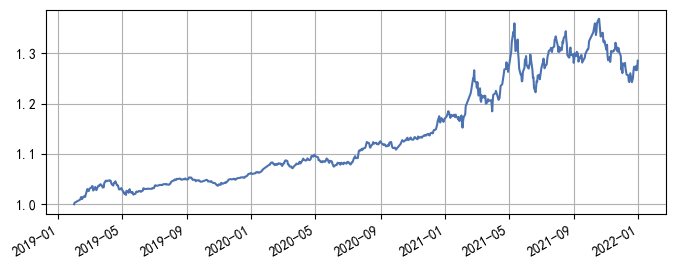

In [9]:
factor_max_sharpe_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

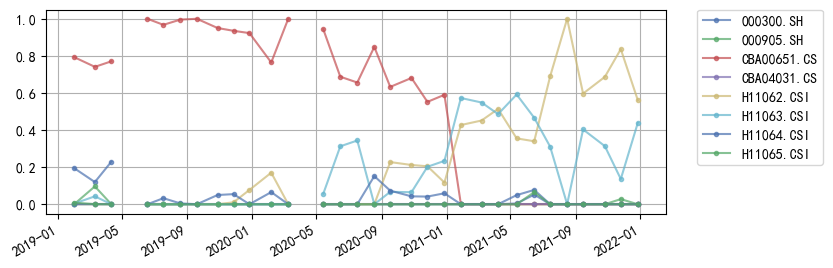

In [10]:
weights = pd.concat(list(factor_max_sharpe_backtest._historcial_weights.values()), axis=1).T
weights.index = list(factor_max_sharpe_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [11]:
factor_pca_max_sharpe_backtest = BacktestManager(
    MvoStrategy(max_sharp=True, asset_alpha=asset_alpha_pca), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
factor_pca_max_sharpe_backtest.run()

  3%|▎         | 23/709 [00:00<00:06, 104.78it/s]

('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
2019-01-31 00:00:00: skip


 16%|█▌        | 111/709 [00:00<00:04, 138.94it/s]

('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
2019-06-18 00:00:00: skip


 37%|███▋      | 265/709 [00:02<00:02, 151.50it/s]

('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
2020-02-06 00:00:00: skip
Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
2020-03-09 00:00:00: skip


 49%|████▉     | 350/709 [00:02<00:02, 145.49it/s]

('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
2020-06-15 00:00:00: skip
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
2020-07-17 00:00:00: skip


100%|██████████| 709/709 [00:05<00:00, 134.90it/s]


<AxesSubplot:>

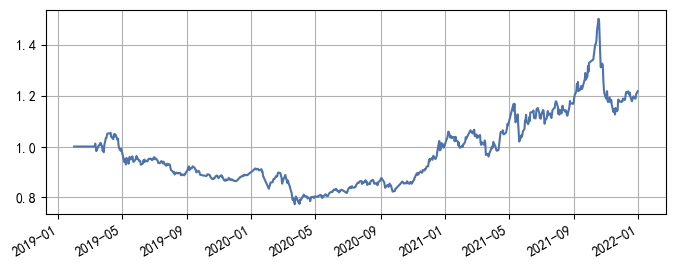

In [12]:
factor_pca_max_sharpe_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

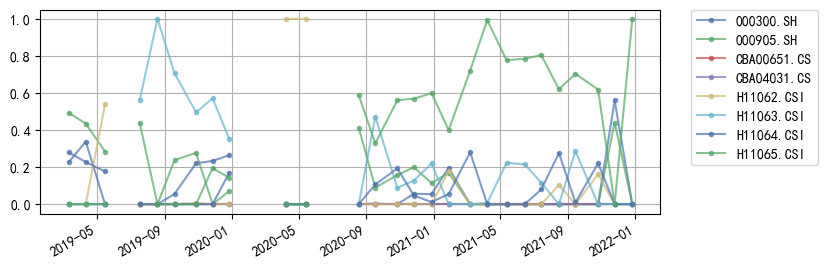

In [13]:
weights = pd.concat(list(factor_pca_max_sharpe_backtest._historcial_weights.values()), axis=1).T
weights.index = list(factor_pca_max_sharpe_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

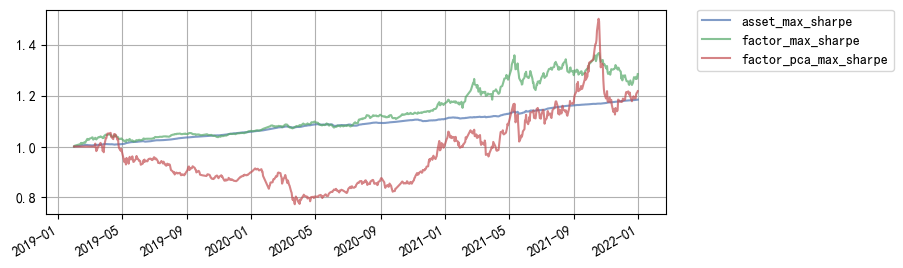

In [14]:
max_sharpe_values = pd.DataFrame({
    'asset_max_sharpe': asset_max_sharpe_backtest.getHistoricalValue(scale=True), 
    'factor_max_sharpe': factor_max_sharpe_backtest.getHistoricalValue(scale=True), 
    'factor_pca_max_sharpe': factor_pca_max_sharpe_backtest.getHistoricalValue(scale=True), 
})
max_sharpe_values.plot(figsize=(8,3), grid=True, alpha=0.7)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [15]:
# sharpe
sharpe = ((max_sharpe_values.iloc[-1]/max_sharpe_values.iloc[0]) ** (252/max_sharpe_values.shape[0]) - 1 - 0.015) / (max_sharpe_values.pct_change().std() * 252**0.5)
sharpe

asset_max_sharpe         5.047926
factor_max_sharpe        0.913351
factor_pca_max_sharpe    0.306502
dtype: float64